In [2]:
# MLP(Multi-Layer Perceptron) - 필기체손글씨 MNIST Dataset

# 딥러닝 MLP 아키텍처
# - 학습데이터 -> 입력층>은닉층>ReLU>Dropout>출력층>Softmax -> 손실함수

# 입력층
# - (28,28) 크기를 가지는 2차원 이미지를 784개(28x28)의 길이를 갖는 1차원 벡터로 변환해서 은닉층으로 전달
# 은닉층
# - 일반적으로 1개 이상의 은닉층으로 이루어지며 각각의 은닉층은 내부에 많은 노드(node)로 구성
# - 은닉층 개수과 노드 개수는 학습데이터와 성능을 고려하여 최적의 값을 찾아야 하는 하이퍼 파라미터
# ReLU
# - 활성화함수로서 입력값이 0보다 크면 입력값 그대로 내보내고, 0보다 작으면 0을 출력하는 비선형함수
# Dropout
# - 학습데이터에 대해 과적합(overfitting)을 줄이기 위해 신경망 뉴런을 주어진 확률값에 따라 부분적으로 제거(drop)해주는 함수
# 출력층
# - 출력층 노드 개수는 정답(label) 개수와 같은 10개로 설정
# - 학습데이터의 정답은 0~9까지 총 10개 가운데 하나의 숫자로 표현되기 때문에 출력층 노드 개수가 또한 정답 개수와 동일한 10개
# Softmax
# - 다중 클래스 분류 모델을 만들때 사용
# - 입력된 벡터의 각 요소를 0~1 사이의 확률값으로 변환해주는 함수


In [3]:
# import, GPU 설정
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('pytorch version : ', torch.__version__, ', device : ', DEVICE)

pytorch version :  2.7.1+cu118 , device :  cuda


In [4]:
# MNIST Dataset 다운로드
train_dataset = datasets.MNIST(root='.\\data\\MNIST_data',
                               train=True, # train
                               transform=transforms.ToTensor(), # 이미지 픽셀값 0~255까지의 값을 0~1 사이의 값을 변환
                               download=True)

test_dataset = datasets.MNIST(root='.\\data\\MNIST_data',
                               train=False, # test
                               transform=transforms.ToTensor(),
                               download=True)

100%|██████████| 9.91M/9.91M [00:09<00:00, 1.06MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:03<00:00, 544kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


In [5]:
# 데이터 확인
print(len(train_dataset), len(test_dataset))

60000 10000


In [6]:
# MNIST Dataset 분리(train : validation = 85% : 15%)
train_dataset_size = int(len(train_dataset) * 0.85) # train 85%
validation_dataset_size = int(len(train_dataset) * 0.15) # validation 15%
train_dataset, validation_dataset = random_split(dataset=train_dataset,
                                                 lengths=[train_dataset_size, validation_dataset_size])

In [7]:
# 분리된 데이터 확인
print(len(train_dataset), len(validation_dataset), len(test_dataset))

51000 9000 10000


In [8]:
# batch, Dataloader
BATCH_SIZE = 32

train_dataset_loader = DataLoader(dataset=train_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=True)

validation_dataset_loader = DataLoader(dataset=validation_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)

test_dataset_loader = DataLoader(dataset=test_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)

{0: '0 - zero', 1: '1 - one', 2: '2 - two', 3: '3 - three', 4: '4 - four', 5: '5 - five', 6: '6 - six', 7: '7 - seven', 8: '8 - eight', 9: '9 - nine'}


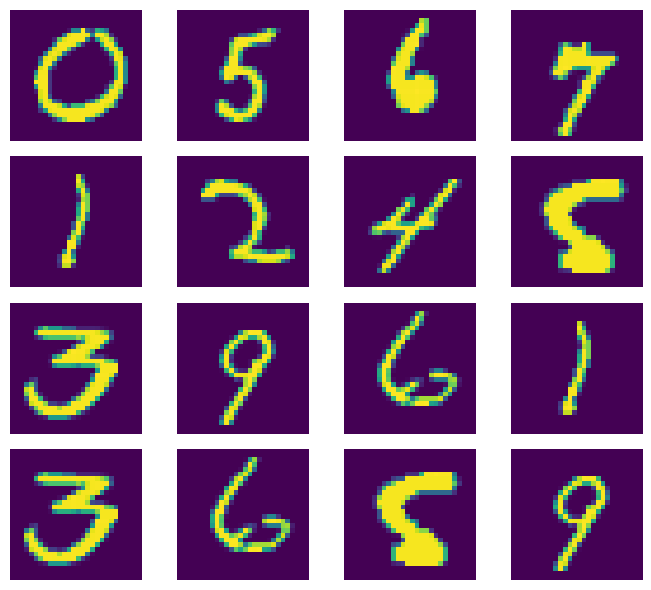

In [9]:
# MNIST Dataset 1개 배치 데이터 확인
images, labels = next(iter(train_dataset_loader))

# labels map 생성
labels_map = { v:k for k, v in train_dataset.dataset.class_to_idx.items() }
print(labels_map)

plt.figure(figsize=(7,6))
cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    
    plt.subplot(cols, rows, i)
    plt.imshow(torch.permute(img, (1,2,0)))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
# MLP Model
class MLPDeepLearningModel(nn.Module):
    # model 정의 - 아키텍처를 구성하는 다양한 계층(layer)을 정의
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.flatten(x) # 입력층
        x = self.fc1(x) # 은닉층
        x = self.relu(x) # 활성화함수 ReLU(비선형함수)
        x = self.dropout(x) # overfitting 방지
        x = self.fc2(x) # 출력층
        return x

In [11]:
# Model 객체 생성
model = MLPDeepLearningModel().to(DEVICE)

# loss function, CrossEntropyLoss 손실함수에는 Softmax 함수 포함되어 있음
loss_function = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In [12]:
# Model train 함수
def model_train(dataloader, model, loss_function, optimizer):
    model.train() # 확습모드

    train_loss_sum = 0
    train_correct = 0
    train_total = 0
    total_train_batch = len(dataloader)

    for images, labels in dataloader:
        # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
        x_train = images.view(-1, 28 * 28).to(DEVICE)
        y_train = labels.to(DEVICE)

        # 모델 예측값 게산
        outputs = model(x_train)

        # 손실함수값 계산
        loss = loss_function(outputs, y_train)

        # 오차역전파
        optimizer.zero_grad() # 미분 연산 초기화
        loss.backward() # 미분 연산
        optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

        train_loss_sum += loss.item()
        train_total += y_train.size(0)
        train_correct += (torch.argmax(outputs, 1) == y_train).sum().item()
    train_avg_loss = train_loss_sum / total_train_batch # 평균 오차 계산
    train_avg_accuracy = 100 * train_correct / train_total # 평균 정확도 계산

    return train_avg_loss, train_avg_accuracy

In [13]:
# Model evaluate 함수
def model_evaluate(dataloader, model, loss_function, optimizer):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        val_loss_sum = 0
        val_correct = 0
        val_total = 0
        total_val_batch = len(dataloader)

        for images, labels in dataloader:
            # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
            x_val = images.view(-1, 28 * 28).to(DEVICE)
            y_val = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_val)

            # 손실함수값 계산
            loss = loss_function(outputs, y_val)

            # 오차역전파
            # optimizer.zero_grad() # 미분 연산 초기화
            # loss.backward() # 미분 연산
            # optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

            val_loss_sum += loss.item()
            val_total += y_val.size(0)
            val_correct += (torch.argmax(outputs, 1) == y_val).sum().item()
        val_avg_loss = val_loss_sum / total_val_batch # 평균 오차 계산
        val_avg_accuracy = 100 * val_correct / val_total # 평균 정확도 계산

        return val_avg_loss, val_avg_accuracy

In [ ]:
# Model test 함수
def model_test(dataloader, model):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        test_loss_sum = 0
        test_correct = 0
        test_total = 0
        total_test_batch = len(dataloader)

        for images, labels in dataloader:
            # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
            x_test = images.view(-1, 28 * 28).to(DEVICE)
            y_test = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_test)

            # 손실함수값 계산
            loss = loss_function(outputs, y_test)

            # 오차역전파
            # optimizer.zero_grad() # 미분 연산 초기화
            # loss.backward() # 미분 연산
            # optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

            test_loss_sum += loss.item()
            test_total += y_test.size(0)
            test_correct += (torch.argmax(outputs, 1) == y_test).sum().item()
        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100 * test_correct / test_total

        print('accuracy = ', test_avg_accuracy, ', loss = ', test_avg_loss)

In [15]:
# Model 학습
train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()

EPOCHS = 20

for epoch in range(EPOCHS):
    # train
    train_avg_loss, train_avg_accuracy = model_train(dataloader=train_dataset_loader,
                                                     model=model,
                                                     loss_function=loss_function,
                                                     optimizer=optimizer)
    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)

    # evaluate
    val_avg_loss, val_avg_accuracy = model_evaluate(dataloader=validation_dataset_loader,
                                                     model=model,
                                                     loss_function=loss_function,
                                                     optimizer=optimizer)
    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)

    # print
    print(
        'epoch : ', '%02d' % (epoch + 1),
        'train loss = ', '{:4f}'.format(train_avg_loss), ', train acc = ', '{:4f}'.format(train_avg_accuracy),
        'val loss = ', '{:4f}'.format(val_avg_loss), ', val acc = ', '{:4f}'.format(val_avg_accuracy)
    )

# time
end_time = datetime.now()
print('elapsed time => ', end_time -start_time)

epoch :  01 train loss =  0.964419 , train acc =  77.486275 val loss =  0.475845 , val acc =  87.722222
epoch :  02 train loss =  0.432034 , train acc =  87.847059 val loss =  0.374565 , val acc =  89.800000
epoch :  03 train loss =  0.361667 , train acc =  89.539216 val loss =  0.332582 , val acc =  90.700000
epoch :  04 train loss =  0.323556 , train acc =  90.819608 val loss =  0.304498 , val acc =  91.300000
epoch :  05 train loss =  0.295921 , train acc =  91.613725 val loss =  0.281947 , val acc =  92.022222
epoch :  06 train loss =  0.273495 , train acc =  92.254902 val loss =  0.261849 , val acc =  92.733333
epoch :  07 train loss =  0.252886 , train acc =  92.825490 val loss =  0.246195 , val acc =  93.166667
epoch :  08 train loss =  0.235420 , train acc =  93.307843 val loss =  0.232062 , val acc =  93.666667
epoch :  09 train loss =  0.220627 , train acc =  93.749020 val loss =  0.218964 , val acc =  94.066667
epoch :  10 train loss =  0.211127 , train acc =  94.056863 val 

In [16]:
# Test Dataset 정확도, 오차 테스트
model_test(dataloader=test_dataset_loader,
            model=model)

(0.12321938823323887, 96.34)

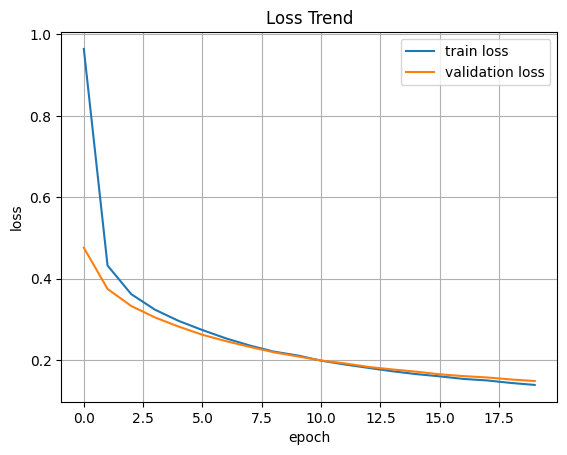

In [17]:
# 시각화 - 손실함수
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')
plt.grid()
plt.legend(loc='best')
plt.show()


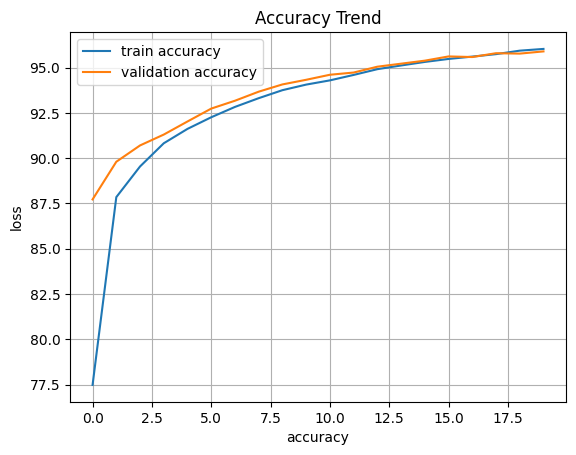

In [18]:
# 시각화 - 정확도
plt.title('Accuracy Trend')
plt.xlabel('accuracy')
plt.ylabel('loss')
plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')
plt.grid()
plt.legend(loc='best')
plt.show()


In [19]:
# Save the model checkpoint
torch.save(model.state_dict(), '.\\models\\model_mlp_mnist.ckpt')